<a href="https://colab.research.google.com/github/Asuna-sama-1/A-B-Testing-Analysis/blob/main/Mobile_Games_A_B_Testing_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A/B Testing Results Analysis** 

## Rounds Played

In [120]:
import pandas as pd
import numpy as np 
import random 
import statistics
from scipy.stats import stats,norm
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

random.seed(42)

In [84]:
# read data 
data = pd.read_csv('cookie_cats.csv')
data.tail(3)

,userid,version,sum_gamerounds,retention_1,retention_7
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [110]:
data['version'] = np.where(data['version']== 'gate_30', 'A','B')

In [85]:
print(len(data.userid.unique()),'rows of users data were collected.')

90189 rows of users data were collected.


In [86]:
if len(data[data['version'] == 'gate_30']) + len(data[data['version'] == 'gate_40']) == len(data.userid.unique()):
  print("Each user is test with one version!")
  print(len(data[data['version'] == 'gate_30']),'users were in gate 30.')
  print(len(data[data['version'] == 'gate_40']),'users were in gate 40.' )
else: 
  print("There are user are test with more than one version")

Each user is test with one version!
44700 users were in gate 30.
45489 users were in gate 40.


### Data cleaning

1. identify outliers using histgram and boxplot
2. removed outliers ( = 0 and > 3000) 

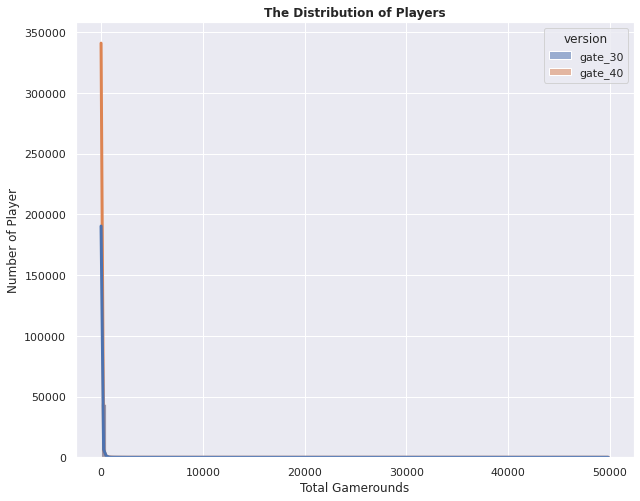

In [90]:
#using histgram to visualize any outliers 

sns.set(rc={'figure.figsize':(10,8)})
sns.histplot(data=data, x="sum_gamerounds", kde=True,hue="version",line_kws={"lw":3},bins=100)
plt.title("The Distribution of Players", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

In [92]:
# dealling with users who played 0 rounds of game
print('There are', data[ data['sum_gamerounds']==0].shape[0],'users who did not play the game at all.')
data = data[data['sum_gamerounds']!=0].reset_index()

There are 3994 users who did not play the game at all.


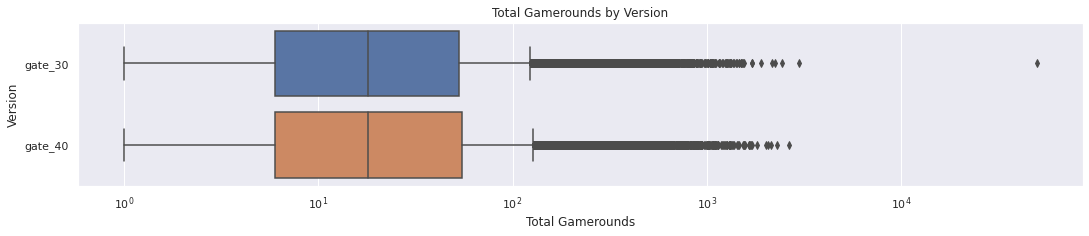

In [93]:
# dealling with outliers
# Total number of games distribution in log-scale

sns.set(rc={'figure.figsize':(18,3)})
ax=sns.boxplot(y = data.version, x = data.sum_gamerounds)
ax.set_xscale('log')
plt.title("Total Gamerounds by Version")
plt.xlabel("Total Gamerounds")
plt.ylabel("Version")
plt.show()

Outlier detected, thus remove rows with more than 3000 rounds played

In [98]:
data = data[ data['sum_gamerounds']<3000].reset_index()

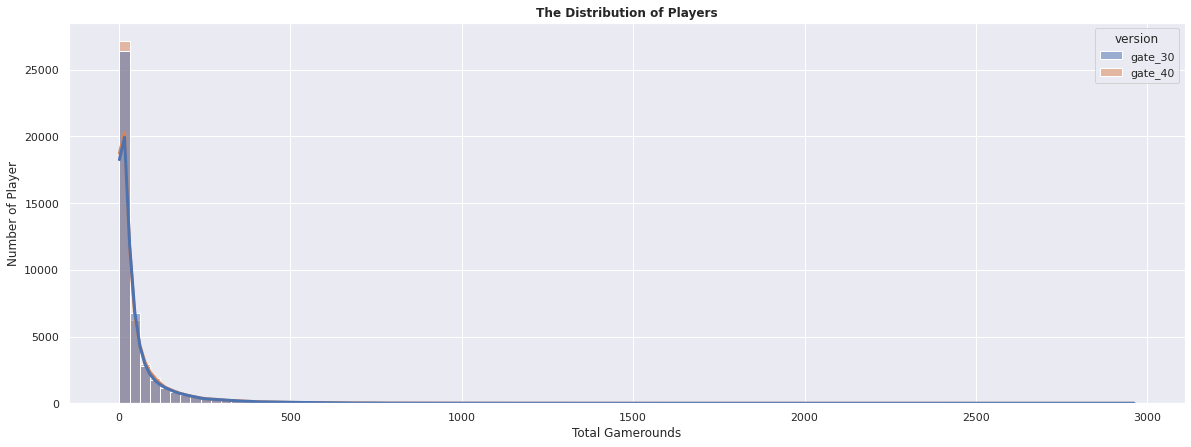

In [101]:
# visualization after remove outliers 

sns.set(rc={'figure.figsize':(20,7)})
sns.histplot(data=data, x="sum_gamerounds", kde=True,hue="version",line_kws={"lw":3},bins=100)
plt.title("The Distribution of Players", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

In [103]:
data.sum_gamerounds.describe()

count    86194.000000
mean        53.698297
std        104.425174
min          1.000000
25%          6.000000
50%         18.000000
75%         54.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [112]:
summary = data.groupby('version').sum_gamerounds.agg(['sum','mean','median','max','min'])
summary

,sum,mean,median,max,min
version,,,,,
A,2294941,53.667766,18.0,2961,1
B,2333530,53.728357,18.0,2640,1


In [118]:
(summary['sum'][1]-summary['sum'][0])/summary['sum'][0]*100

1.6814811361163533

**Summary:** There are 90189 unique user data were collected for this exprienment. 44700 users were in gate 30 (version A) and 45489 users were in gate 40(version B). 
- There are outliers detected: removed players who has 0 round played and played more than 3000 rounds. 
- Total number of rounds played for version A is slightly higher than Version A by **1.68%**
- Average number of rounds played are **53.7** for both version A and B. 
- Meian number of rounds played are **18.0** for both version A and B. 

### A/B Testing

#### Statistical Assumptions

**1. Indeependence**

**2. Normality of data**

**3. Homogeneity of variance**

(If pass all, then **parametric**, else **non-parametric**)


##### Check Normality -(graph)

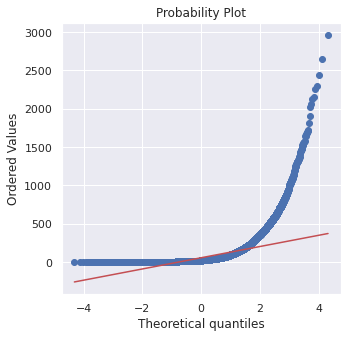

In [125]:
# 1. QQ Plot 
# If our data comes from a normal distribution, we should see all the points sitting on the straight line.
import pylab
stats.probplot(data.sum_gamerounds, dist='norm', plot=pylab)
pylab.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


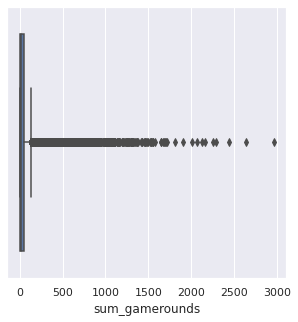

In [126]:
# 2. Box Plot 
# If your variable has a normal distribution, we should see the mean and median in the center.

ax = sns.boxplot(data.sum_gamerounds)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


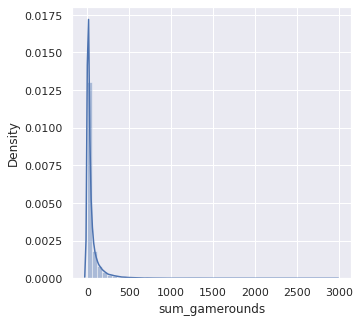

In [127]:
# 3. Histogram 
#If your variable has a normal distribution, we should see a bell curve.

sns.distplot(data.sum_gamerounds)

##### Check Normality -(Statistical test)

In [132]:
# 1. Shapiro- Wilk Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import shapiro 

def Shapiro_wilk(data):
  stat, p = shapiro(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

Shapiro_wilk(data.sum_gamerounds)

Stat = 0.492, p = 0.000

Probably Not Gaussian



/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [134]:
# 2.  D’Agostino’s K-squared Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import normaltest 

def k_squared(data):
  stat, p = normaltest(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

k_squared(data.sum_gamerounds)

Stat = 98529.876, p = 0.000

Probably Not Gaussian



In [142]:
# 3.  Anderson-Darling Normality Test
#It gives a range of critical values, at which the null hypothesis can be failed to rejected if the calculated statistic is less than the critical value.

from scipy.stats import anderson 

def anderson_test(data):
  result = anderson(data)
  print('Stat = %.3f\n' %(result.statistic))
  for i in range(len(result.critical_values)):
    sig_lev, crit_val = result.significance_level[i], result.critical_values[i]
    if result.statistic < crit_val:
      print(f"Probably Gaussian: {crit_val} critical value at {sig_lev} significance level")
    else:
      print(f"Probably Not Gaussian: {crit_val} critical value at {sig_lev} significance level")

anderson_test(data.sum_gamerounds)

Stat = 12556.470

Probably Not Gaussian: 0.576 critical value at 15.0 significance level
Probably Not Gaussian: 0.656 critical value at 10.0 significance level
Probably Not Gaussian: 0.787 critical value at 5.0 significance level
Probably Not Gaussian: 0.918 critical value at 2.5 significance level
Probably Not Gaussian: 1.092 critical value at 1.0 significance level


In [143]:
# 4. Chi-Square Normality Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import chisquare 

def chisquare_test(data):
  stat, p = chisquare(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

chisquare_test(data.sum_gamerounds)

Stat = 17503379.103, p = 0.000

Probably Not Gaussian



In [152]:
# 5.  Lilliefors Normality Test
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from statsmodels.stats.diagnostic import lilliefors

def lilliefors_test(data):
  stat, p = lilliefors(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

lilliefors_test(data.sum_gamerounds)

Stat = 0.307, p = 0.000

Probably Not Gaussian



In [153]:
# 6.   Jarque–Bera Normality Test
# only works for > 2000
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import jarque_bera

def jarque_bera_test(data):
  stat, p = jarque_bera(data)
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

jarque_bera_test(data.sum_gamerounds)

Stat = 14855626.496, p = 0.000

Probably Not Gaussian



In [156]:
# 6. Kolmogorov-Smirnov Normality Test
# on 1 or 2 samples (goodness of fit)
#If the p-value ≤ 0.05, then we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian.
#If the p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

from scipy.stats import kstest

def k_stest(data):
  stat, p = kstest(data,'norm')
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

k_stest(data.sum_gamerounds)

Stat = 0.913, p = 0.000

Probably Not Gaussian



#### Non-Parametric Test


##### Probability Samplling 

For non-parametric test, we are trying to compare the sample mean or sample median of verision A and B. It needs resampling method: **`Bootstrapping and Boostrap Quantile`** method, respectively.
- **Bootstrapping** is a statistical procedure that resamples a single dataset to create many simulated samples.
-**Boostrap Quantile** is a quantile estimator that is the median of a set of quantiles calculated by re-sampling the original sample a large number of times and computing a quantile for each sample


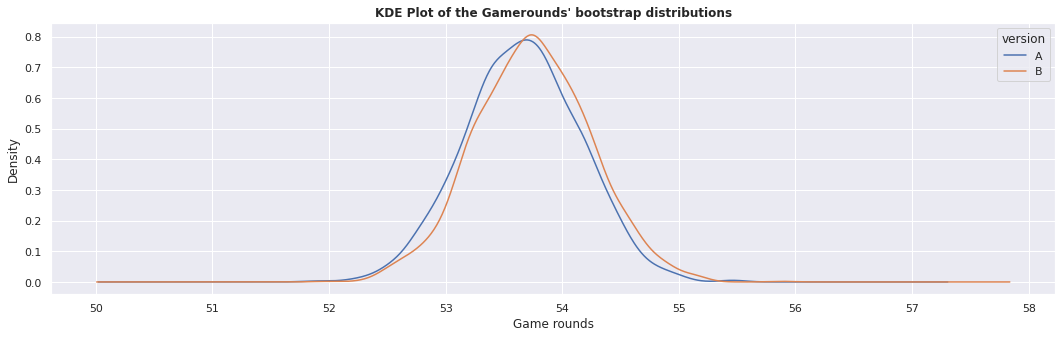

In [159]:
# boostrapping for resample 
n = 2000     #number of samples 
bootstrap_sum = pd.DataFrame([data.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean() for i in range(n)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Gamerounds' bootstrap distributions", fontweight="bold")
plt.xlabel("Game rounds")
plt.show()

In [172]:
bootstrap_sum['diff_mean'] = bootstrap_sum['B'] - bootstrap_sum['A']
mean_pos_count = len(bootstrap_sum[bootstrap_sum['diff_mean'] > 0])
p_mean_diff = mean_pos_count/n
p_mean_diff

#If the p-value is larger than the chosen significance level then we can state that we can’t reject the null. 
#Hence, there is not enough evidence to state that there is a statistically significant difference in Control and Experimental sample means.

0.5525

In [170]:
alpha = 0.05
z_mean = np.mean(bootstrap_sum['B'])- np.mean(bootstrap_sum['A'])
z_sigma = np.sqrt((np.var(bootstrap_sum['B'])/n + np.var(bootstrap_sum['A'])/n))
print("           Mean of (verison B - verison A):", z_mean)
print("Standard Error of (verison B -  verison A):", z_sigma)
print("             CI of (verison B - verison A):", [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma] )

           Mean of (verison B - verison A): 0.08748718899640551
Standard Error of (verison B -  verison A): 0.015672991681790708
             CI of (verison B - verison A): [0.05676868977009987, 0.11820568822271114]


In [169]:
CI = np.percentile(bootstrap_sum['diff_mean'], [2.5, 97.5])
CI

array([-1.28041765,  1.51660147])

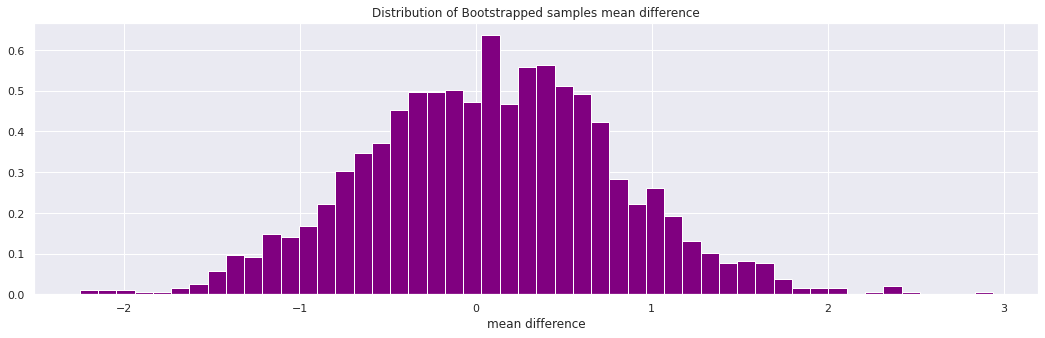

In [171]:
counts,bins,ignored = plt.hist(bootstrap_sum['diff_mean'],50,density = True,color = 'purple')
plt.xlabel("mean difference")
plt.title("Distribution of Bootstrapped samples mean difference")
plt.show()

##### Mann-Whitney U Tes

**Parametric** tests are used only when a normal (or close to normal) distribution is assumed. 

- t-test 
- ANOVA


**Non-parametric** tests are used when continuous data is not normally distributed or when data is discrete. 

- **chi-squared** : Large N, identify and you want to identify whether there exist a relationship between control and experimental groups


- **Fisher’s exact tests** :  Small N, identify and you want to identify whether there exist a relationship between control and experimental groups

- **Mann–Whitney U-test** : Small N or large N, skewed sampling distributions, testing the difference in medians between control and experimental groups


**H0 (Null hypothesis)** : There is **No** significant differene in sum_gamerounds between two versions

**H1 (Alternative hypothesis)**:  There is significant differene in sum_gamerounds between two versions 

In [182]:
from scipy.stats import mannwhitneyu

sum_gamerounds_A = data[data.version=='A'].sum_gamerounds
sum_gamerounds_B = data[data.version=='B'].sum_gamerounds

def mannwhitneyfunc(value1,value2):
    stat, p=mannwhitneyu(value1,value2)
    alpha=0.05 

    print('p=%.4f , alpha=%.2f \n'%(p,alpha))
    if p > alpha:
        print('Fail to reject H0; Two version have no significant difference')
    else:
        print('Have enough envidence to reject H0; Two version have a significant difference')

mannwhitneyfunc(sum_gamerounds_A,sum_gamerounds_B)

p=0.0588 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


**Summary:**

- Two versions has no significant changes in number of rounds played. 

## Retention

### Data exploratin

In [185]:
# what is the overall first day retention rate?

data.retention_1.sum()/data.retention_1.count()*100

46.48351393368448

In [186]:
# what is the first day retention rate for each version?

data.groupby('version').retention_1.sum()/data.groupby('version').retention_1.count()*100

version
A    46.754127
B    46.217075
Name: retention_1, dtype: float64

In [187]:
# what is the overall 7th day retention rate?

data.retention_7.sum()/data.retention_7.count()*100

19.434067336473536

In [188]:
# what is the 7th day retention rate for each version?

data.groupby('version').retention_7.sum()/data.groupby('version').retention_7.count()*100

version
A    19.842383
B    19.032050
Name: retention_7, dtype: float64

In [189]:
# How much does the retention drop from first day to 7th day?

(data.groupby('version').retention_1.sum() - data.groupby('version').retention_7.sum())/data.groupby('version').retention_1.sum()*100

version
A    57.560146
B    58.820306
dtype: float64

In [190]:
data.groupby('version').agg({'retention_1':'mean','retention_7':'mean'})

,retention_1,retention_7
version,,
A,0.467541,0.198424
B,0.462171,0.190321


Summary: 
- The overrall day-1 retention rate is **46.5%**; version A has **46.8%** and version B has **46.2%** 
- The overrall day-7 retention rate is **19.4%**; version A has **19.8%** and version B has **19.0%** 
- Version A has higher day1 and day-7 retention rate than version B



### A/B Test for Retention Rate


**chi-2 test**

- Non-parametric(data is discrete)
- Large N
- identify whether there exist a relationship between 2 groups

- Significance level(Alpha) = 0.5 = probability of rejecting the null hypothesis while it is true Type I

**H0 (Null hypothesis)** : There is **No** significant differene in retention rate between two versions 

P(retention rate of B) - P(retention rate of A) <= 0 

**H1 (Alternative hypothesis)**:  There is significant differene in retention rate between two versions 

P(retention rate of B) - P(retention rate of A) > 0 


**chi2_contingency**

> trying to figure out if two groups has any significant difference

**chisquarey**

> trying to figure out if the discrect RV has any significant difference from expected distribution



In [194]:
# Chi-square test of independence of variables in a contingency table - Pearson's chi-square test or the chi-square test of association
from scipy.stats import chi2_contingency

def chi2_con_test(data):
    chi2, p, dof, ex = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two verisions have no significant difference')
    else:
        print('Two verisions have a significant difference')

In [199]:
day1_cross_table = pd.crosstab(data["version"], data["retention_1"]) 
day7_cross_table = pd.crosstab(data["version"], data["retention_7"]) 

day1_cross_table

retention_1,False,True
version,,
A,22769,19993
B,23359,20073


In [203]:
print('Day 1 retention rate\n')
chi2_con_test(day1_cross_table)
print('*'*50)
print('Day 7 retention rate\n')
chi2_con_test(day7_cross_table)

Day 1 retention rate

p=0.1155 , alpha=0.05 
Two verisions have no significant difference
**************************************************
Day 7 retention rate

p=0.0027 , alpha=0.05 
Two verisions have a significant difference


**Summary:**

- Two versions has no significant changes in Day 1 Retension. 
- Two versions has a significant changes in Day 7 Retension.  Version B has a negative effect in day 7 retention rate. 
